###The best area for a pub in Toronto

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

Web scraping for postal code data

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())
df = pd.read_html(table_str)[0]
df.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

Cleaning Dataset

In [3]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df_dropna.rename(columns={'Postal Code' : 'PostalCode'}, inplace=True)
df = df_dropna
df.head()

PostalCode           Borough                                Neighbourhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [4]:
df_grouped = df.groupby(['Borough', 'PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

Borough PostalCode                      Neighbourhood
0  Central Toronto        M4N                      Lawrence Park
1  Central Toronto        M4P                   Davisville North
2  Central Toronto        M4R  North Toronto West, Lawrence Park
3  Central Toronto        M4S                         Davisville
4  Central Toronto        M4T        Moore Park, Summerhill East

In [7]:
df = df_grouped
df = df[['PostalCode', 'Borough', 'Neighbourhood']]
df.head()

PostalCode          Borough                      Neighbourhood
0        M4N  Central Toronto                      Lawrence Park
1        M4P  Central Toronto                   Davisville North
2        M4R  Central Toronto  North Toronto West, Lawrence Park
3        M4S  Central Toronto                         Davisville
4        M4T  Central Toronto        Moore Park, Summerhill East

Getting Latitude and Longitude Data

In [8]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Merging datasets

In [9]:
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode          Borough  ...   Latitude  Longitude
0        M4N  Central Toronto  ...  43.728020 -79.388790
1        M4P  Central Toronto  ...  43.712751 -79.390197
2        M4R  Central Toronto  ...  43.715383 -79.405678
3        M4S  Central Toronto  ...  43.704324 -79.388790
4        M4T  Central Toronto  ...  43.689574 -79.383160

[5 rows x 5 columns]

Visualizing boroughs and neighbourhoods in folium map

In [12]:
df_toronto = df
df_toronto.head()
boroughs = df_toronto['Borough'].unique().tolist()
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

Getting Foursquare venues data

In [15]:
CLIENT_ID = 'VLUA5S1IWAM2OGUXXFMD2DGWS4L4JURTWBPHJ3S4I1RZ5VU2' 
CLIENT_SECRET = 'XYUIAOUDSC2HVSXSPC12DPAXNFCST0KVH0PKAHGJITUIXQRQ' 
VERSION = '20180605'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [24]:
toronto_venues.head()

Neighbourhood  Neighborhood Latitude  ...  Venue Longitude    Venue Category
0     Lawrence Park              43.728020  ...       -79.394382              Park
1     Lawrence Park              43.728020  ...       -79.391681  Business Service
2     Lawrence Park              43.728020  ...       -79.382860       Swim School
3     Lawrence Park              43.728020  ...       -79.382805          Bus Line
4  Davisville North              43.712751  ...       -79.387776              Park

[5 rows x 7 columns]

Checking if there are Pub Venues in the Dataset

In [43]:
"Pub" in toronto_venues['Venue Category'].unique()

True

One Hot Encoding

In [33]:
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 

fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_onehot.head()

Neighbourhoods  Accessories Store  ...  Women's Store  Yoga Studio
0     Lawrence Park                  0  ...              0            0
1     Lawrence Park                  0  ...              0            0
2     Lawrence Park                  0  ...              0            0
3     Lawrence Park                  0  ...              0            0
4  Davisville North                  0  ...              0            0

[5 rows x 273 columns]

Group by neighbourhoods and cleaning data

In [36]:
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()

to_grouped.head()

Neighbourhoods  ...  Yoga Studio
0                                        Agincourt  ...          0.0
1                           Alderwood, Long Branch  ...          0.0
2  Bathurst Manor, Wilson Heights, Downsview North  ...          0.0
3                                  Bayview Village  ...          0.0
4                Bedford Park, Lawrence Manor East  ...          0.0

[5 rows x 273 columns]

In [44]:
pub = to_grouped[["Neighbourhoods","Pub"]]
pub.head(10) 

Neighbourhoods       Pub
0                                          Agincourt  0.000000
1                             Alderwood, Long Branch  0.125000
2    Bathurst Manor, Wilson Heights, Downsview North  0.000000
3                                    Bayview Village  0.000000
4                  Bedford Park, Lawrence Manor East  0.041667
5                                        Berczy Park  0.016949
6                        Birch Cliff, Cliffside West  0.000000
7       Brockton, Parkdale Village, Exhibition Place  0.000000
8  Business reply mail Processing Centre, South C...  0.000000
9  CN Tower, King and Spadina, Railway Lands, Har...  0.000000

Cluster using Kmeans and KElbowVisualizer

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = pub.drop(['Neighbourhoods'], axis=1)
kmeans.fit(X)
kmeans.labels_[0:10]

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

scores = [get_inertia(x) for x in range(2, 21)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  if __name__ == '__main__':


Finding K

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b5f883c10>,
                 k=None, metric=None, model=None, timings=True)

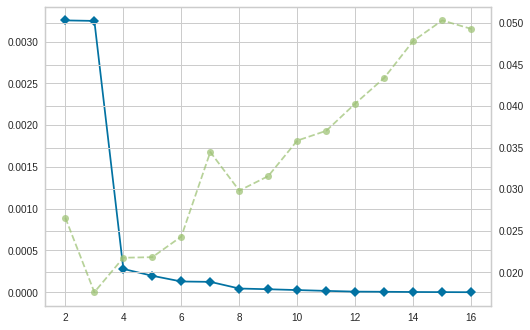

In [48]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,17))

visualizer.fit(X)

Running KMeans with k=4

In [49]:
kclusters = 4

toronto_grouped_clustering = pub.drop('Neighbourhoods', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

array([3, 2, 3, 3, 0, 3, 3, 3, 3, 3], dtype=int32)

Creating Dataframe with clusters

In [50]:
to_merged = pub.copy()

to_merged["Cluster Labels"] = kmeans.labels_
to_merged.head()

Neighbourhoods       Pub  Cluster Labels
0                                        Agincourt  0.000000               3
1                           Alderwood, Long Branch  0.125000               2
2  Bathurst Manor, Wilson Heights, Downsview North  0.000000               3
3                                  Bayview Village  0.000000               3
4                Bedford Park, Lawrence Manor East  0.041667               0

Merging dataframes

In [54]:
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhoods")

print(to_merged.shape)
to_merged.head()

(2128, 9)


Neighbourhoods    Pub  ...  Venue Longitude             Venue Category
0               Agincourt  0.000  ...       -79.260203             Breakfast Spot
0               Agincourt  0.000  ...       -79.259208  Latin American Restaurant
0               Agincourt  0.000  ...       -79.258584                     Lounge
0               Agincourt  0.000  ...       -79.267989               Skating Rink
1  Alderwood, Long Branch  0.125  ...       -79.545028                Pizza Place

[5 rows x 9 columns]

Seeing the clusters in map

In [56]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighbourhoods'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

Creating new dataframes with the neighbourhoods of each cluster

In [71]:
df2 = df[['Borough', 'Neighbourhood']]
df2.rename(columns={'Neighbourhood' : 'Neighbourhoods'}, inplace=True)

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df2, cluster1, on='Neighbourhoods')

cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df2, cluster2, on='Neighbourhoods')

cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df2, cluster3, on='Neighbourhoods')

cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df2, cluster4, on='Neighbourhoods')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Comparing clusters with matplotlib

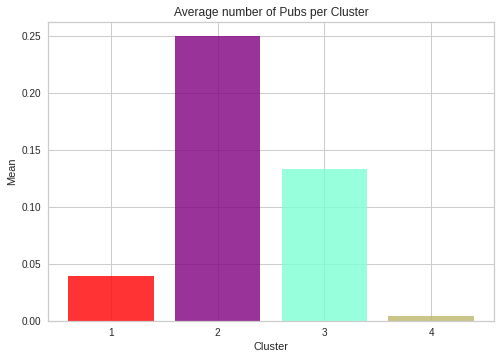

In [73]:
clusters_mean = [df_cluster1['Pub'].mean(),df_cluster2['Pub'].mean(),df_cluster3['Pub'].mean(),
                 df_cluster4['Pub'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Pubs per Cluster')

plt.show()

Checking which borough is in the cluster with highest average of pubs

In [77]:
df_cluster2.head(10)

Borough Neighbourhoods  ...  Venue Longitude     Venue Category
0  East Toronto    The Beaches  ...       -79.293942              Trail
1  East Toronto    The Beaches  ...       -79.297734  Health Food Store
2  East Toronto    The Beaches  ...       -79.297215                Pub
3  East Toronto    The Beaches  ...       -79.292869       Neighborhood

[4 rows x 10 columns]